<a href="https://colab.research.google.com/github/jchen8000/MachineLearning/blob/master/6%20Recommender%20System/Recommendation_Collaborative_Filtering_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommendation System with Neural Network

Make sure to select GPU as Runtime Type in Google Colab.

*Please Note: for some reasons this only works with Runtime Type = GPU on Google Colab, an error occurs if Runtime Type is None or TPU. Looks like a bug with tensorflow.*

---



In [ ]:
%pip install \
  numpy==2.0.2 \
  pandas==2.2.2 \
  scikit-learn==1.6.1 \
  matplotlib==3.10.0 \
  keras==3.9.0 \
  pydot==4.0.1

In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
from pathlib import Path
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pydot
import keras
from keras import layers

## MovieLens dataset

In [ ]:
movielens = 'ml-100k'
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'

datasets_path = Path(f"{movielens}.zip")
movielens_dir = Path(movielens)

if not datasets_path.exists():
    urlretrieve(url, datasets_path)

if not movielens_dir.exists():
    with ZipFile(datasets_path, "r") as zf:
        zf.extractall()

print("Dataset ready at:", movielens_dir.resolve())

In [ ]:
rating_col = ['userid','movieid','rating','timestamp']
ratings = pd.read_csv(
        movielens_dir/"u.data", 
        sep='\t', 
        header=None,
        names=rating_col
    )
ratings = ratings[ratings.groupby("movieid")["movieid"].transform("size") > 30]
ratings = ratings[ratings.groupby("userid")["userid"].transform("size") > 20]
ratings

,userid,movieid,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
3,244,51,2,880606923
5,298,474,4,884182806
6,115,265,2,881171488
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [ ]:
movie_col = ['movieid', 'title', 'releasedate', 'videoreleasedate', 
             'IMDbURL', 'unknown', 'Action', 'Adventure', 'Animation', 
             'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 
             'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 
             'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
             ]
movies = pd.read_csv( movielens_dir/"u.item", 
                     sep='|',
                     header=None,
                     names=movie_col,
                     encoding='latin-1')
movies

,movieid,title,releasedate,videoreleasedate,IMDbURL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Collaborative Filter with Deep Neural Network

Prepare model inputs (user_ids, movie_ids, ratings_vec)

In [ ]:
# Integer-encode users/movies to contiguous indices for Embedding layers
user_codes, user_uniques = pd.factorize(ratings["userid"])
movie_codes, movie_uniques = pd.factorize(ratings["movieid"])

user_ids = user_codes.astype("int32")       # shape (N,)
movie_ids = movie_codes.astype("int32")     # shape (N,)
ratings_vec = ratings["rating"].astype("float32").values  # shape (N,)

n_users  = len(user_uniques)
n_movies = len(movie_uniques)

print("Encoded vocab sizes -> n_users:", n_users, "n_movies:", n_movies)

# Train/test split
X_user_train, X_user_test, X_movie_train, X_movie_test, y_train, y_test = train_test_split(
    user_ids, movie_ids, ratings_vec, test_size=0.2, random_state=42
)

The Keras functional API is a way to create models that are more flexible than the tf.keras.Sequential API. The functional API can handle models with non-linear topology, shared layers, and even multiple inputs or outputs.

Reference: https://keras.io/guides/functional_api/

In [ ]:
def build_recommender(n_users: int, n_movies: int,
                      embed_dim: int = 64,
                      hidden1: int = 64,
                      hidden2: int = 32,
                      dropout1: float = 0.25,
                      dropout2: float = 0.10) -> keras.Model:
    """Builds a simple user–movie embedding recommender with MLP head."""
    # Inputs (ensure integer dtype for Embedding)
    movie_input = layers.Input(shape=(1,), dtype="int32", name="Movie-Input")
    user_input  = layers.Input(shape=(1,), dtype="int32", name="User-Input")

    # Embeddings (input_dim = vocab size; add +1 as you did to be safe)
    movie_vec = layers.Embedding(input_dim=n_movies + 1, output_dim=embed_dim,
                                 name="Movie-Embedding")(movie_input)
    user_vec  = layers.Embedding(input_dim=n_users + 1, output_dim=embed_dim,
                                 name="User-Embedding")(user_input)

    # Flatten
    movie_vec = layers.Flatten(name="Movie-Flatten")(movie_vec)
    user_vec  = layers.Flatten(name="User-Flatten")(user_vec)

    # Concatenate user/movie representations
    x = layers.Concatenate(name="Concat")([movie_vec, user_vec])

    # MLP head
    x = layers.Dense(hidden1, activation="relu", name="Dense-64")(x)
    x = layers.Dropout(dropout1, name="Dropout-0.25")(x)
    x = layers.Dense(hidden2, activation="relu", name="Dense-32")(x)
    x = layers.Dropout(dropout2, name="Dropout-0.10")(x)
    out = layers.Dense(1, name="Score")(x)

    model = keras.Model(inputs=[user_input, movie_input], outputs=out, name="RecommenderMLP")

    # Compile: MSE loss; add RMSE metric for readability
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="mean_squared_error",
        metrics=[keras.metrics.RootMeanSquaredError(name="rmse")]
    )
    return model

model = build_recommender(n_users, n_movies)
model.summary()

Plot the model diagram

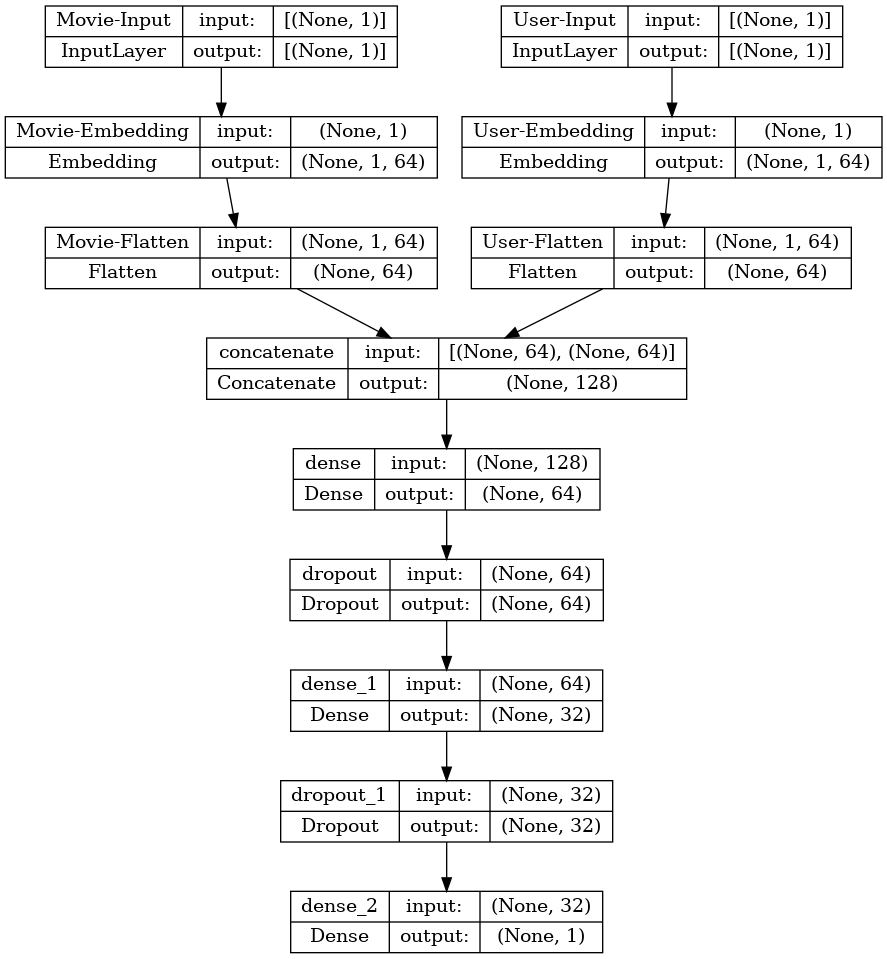

In [ ]:
keras.utils.model_to_dot(model,show_shapes=True, show_layer_names=True).write_svg('cf_model.svg')  
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)


Fit the model (with early stopping)

In [ ]:
batch_size=1024
epochs=200

# Early stopping function
es = keras.callbacks.EarlyStopping(
    monitor="val_rmse",
    mode="min",
    patience=2,
    restore_best_weights=True
)

history = model.fit(
    x=[X_user_train, X_movie_train],
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([X_user_test, X_movie_test], y_test),
    # callbacks=[es],                 # try early stopping as needed
    verbose=2
)

Epoch 1/200
353/353 [==============================] - 21s 52ms/step - loss: 2.4351
Epoch 2/200
353/353 [==============================] - 5s 14ms/step - loss: 1.0891
Epoch 3/200
353/353 [==============================] - 4s 12ms/step - loss: 1.0547
Epoch 4/200
353/353 [==============================] - 4s 12ms/step - loss: 1.0408
Epoch 5/200
353/353 [==============================] - 5s 13ms/step - loss: 1.0228
Epoch 6/200
353/353 [==============================] - 4s 10ms/step - loss: 0.9909
Epoch 7/200
353/353 [==============================] - 4s 11ms/step - loss: 0.9750
Epoch 8/200
353/353 [==============================] - 4s 11ms/step - loss: 0.9560
Epoch 9/200
353/353 [==============================] - 4s 11ms/step - loss: 0.9384
Epoch 10/200
353/353 [==============================] - 4s 11ms/step - loss: 0.9232
Epoch 11/200
353/353 [==============================] - 4s 11ms/step - loss: 0.9081
Epoch 12/200
353/353 [==============================] - 4s 11ms/step - loss: 0.8950


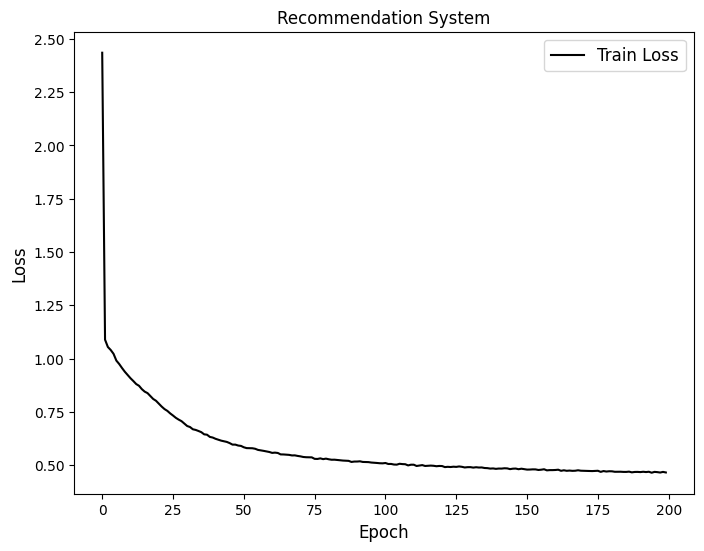

In [10]:
fig = plt.figure(figsize=(8,6))
plt.title('Recommendation System')
plt.plot(history.history['loss'], label="Train Loss", c='k')
plt.xlabel(r'Epoch', fontsize=12)
plt.ylabel(r'Loss', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.savefig("recommendation_neural_network.svg", format="svg", transparent=True, bbox_inches='tight')
plt.show()

Evaluate the model

In [ ]:
test_mse, test_rmse = model.evaluate([X_user_test, X_movie_test], y_test, verbose=0)
print(f"Test MSE:  {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

1/1 [==============================] - 0s 133ms/step
[4.057906] 3
[2.9454386] 3
[2.4572172] 2
[4.2542014] 4
[2.8787317] 2
[4.584563] 5
[3.2600207] 3
[3.659955] 3
[2.8486009] 2
[3.6347203] 5


[None, None, None, None, None, None, None, None, None, None]

## Make Recommendations

Recommend RECOMM_COUNT movies for a specific user RECOMM_USER.

In [ ]:
RECOMM_USER = 660
RECOMM_COUNT = 10

# Build raw → encoded maps
user_to_enc  = pd.Series(index=user_uniques,  data=range(len(user_uniques))).to_dict()
movie_to_enc = pd.Series(index=movie_uniques, data=range(len(movie_uniques))).to_dict()

List movies rated by RECOMM_USER:

In [ ]:
user_ratings = ratings[ratings['userid'] == RECOMM_USER][['userid', 'movieid', 'rating']].copy()

# Encode user & movie IDs for prediction (minimal additions)
enc_user_seen   = np.full(shape=(len(user_ratings),), fill_value=np.int32(user_to_enc[RECOMM_USER]), dtype=np.int32)
enc_movies_seen = user_ratings['movieid'].map(movie_to_enc).astype('int32').values

# Predict with encoded IDs
user_ratings['prediction'] = model.predict([enc_user_seen, enc_movies_seen], batch_size=4096, verbose=0)

# Show rated movies with titles (unchanged)
user_ratings.sort_values(by='rating', ascending=False) \
            .merge(movies[['movieid', 'title']], on='movieid', how='inner')

7/7 [==============================] - 0s 4ms/step


,userid,movieid,rating,prediction,title
0,660,173,5,4.214880,"Princess Bride, The (1987)"
1,660,151,5,3.001507,Willy Wonka and the Chocolate Factory (1971)
2,660,168,5,4.114658,Monty Python and the Holy Grail (1974)
3,660,50,4,4.121457,Star Wars (1977)
4,660,316,4,3.639176,As Good As It Gets (1997)
...,...,...,...,...,...
204,660,120,1,1.273379,Striptease (1996)
205,660,1074,1,2.482523,Reality Bites (1994)
206,660,56,1,2.146750,Pulp Fiction (1994)
207,660,890,1,2.482523,Mortal Kombat: Annihilation (1997)


Make recommendations by following steps:

1. Get all movies from ratings list, except those rated by RECOMM_USER. The movies in the list are not rated (seen) by the user.
2. Remove duplicated movies from the list.
3. Predict ratings by RECOMM_USER for each movie in the list, using the trained model.
4. Sort the list by prediction and take top RECOMM_COUNT movie as recommendations.

In [ ]:
user_ratings = ratings[ratings['userid'] == RECOMM_USER][['userid', 'movieid', 'rating']].copy()

# Encode user & movie IDs for prediction (minimal additions)
enc_user_seen   = np.full(shape=(len(user_ratings),), fill_value=np.int32(user_to_enc[RECOMM_USER]), dtype=np.int32)
enc_movies_seen = user_ratings['movieid'].map(movie_to_enc).astype('int32').values

# Predict with encoded IDs
user_ratings['prediction'] = model.predict([enc_user_seen, enc_movies_seen], batch_size=4096, verbose=0)

# Show rated movies with titles (unchanged)
user_ratings.sort_values(by='rating', ascending=False) \
            .merge(movies[['movieid', 'title']], on='movieid', how='inner')


19/19 [==============================] - 0s 3ms/step


,userid,movieid,prediction,title
0,660,114,4.278964,Wallace & Gromit: The Best of Aardman Animatio...
1,660,169,4.155013,"Wrong Trousers, The (1993)"
2,660,512,4.113422,Wings of Desire (1987)
3,660,199,4.067683,"Bridge on the River Kwai, The (1957)"
4,660,408,4.022201,"Close Shave, A (1995)"
5,660,606,3.994244,All About Eve (1950)
6,660,479,3.973346,Vertigo (1958)
7,660,478,3.964161,"Philadelphia Story, The (1940)"
8,660,480,3.949427,North by Northwest (1959)
9,660,427,3.949427,To Kill a Mockingbird (1962)
